## <u>Introduction</u>

We are using data-set from https://myleott.com/op-spam. And the description of the given data is as follows:-
* 400 truthful positive reviews from TripAdvisor (described in [1])
* 400 deceptive positive reviews from Mechanical Turk (described in [1])
* 400 truthful negative reviews from Expedia, Hotels.com, Orbitz, Priceline, TripAdvisor and Yelp (described in [2])
* 400 deceptive negative reviews from Mechanical Turk (described in [2])

## <u>Main sub-tasks our process will consist</u>

The objective of this project is to identify the falseful and truthful reviews. The project will entail reviewing the cleaning the data, extracting relevant features and then fitting the appropriate model which can then produce correct predictions. The accuracy of the predictions will depends heavily on the right data and features selected and the model selected. This project can be compared to a research process where we look at different machine learning models and which information in the reviews is most reliable for producing the required task which is again detecting spam.

* Cleaning and preparation of each review we retrieve from the given folders.
* Introducing machine learning models
* Implementation and testing of models


## <u>Supervised Learning</u>

The available data for the project is a labeled data where the 'Truthful' and the 'Falseful' data has been classified. Therefore supervised learning approach should be used. 
This type of machine learning is often used for automatic detection and involves training a machine learning model with large amounts of data that is also marked with a correct description/classification of what the data contains, as in this case. Here we can come up with many examples and to mention one of them we could give a model thousands of pictures of dogs and cats, along with a label for each picture that said whether it is was a dog or a cat. During the training process, the model will constantly try to guess the content of the pictures and improve based on whether it guessed right or wrong.
<br>
In other words, each review we use to train the model must be marked with deceptive/truthful so that we can get the model to learn from.


## <u>Importing libraries</u>

In [1]:
#for google colab
#!pip install texthero
#!wget "https://myleott.com/op_spam_v1.4.zip"
#!unzip op_spam_v1.4.zip

In [81]:
import os
import re
import timeit
import numpy as np
import pandas as pd
import texthero as hero
from os import walk
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from unidecode import unidecode
from IPython.display import Image
import nltk
nltk.download('punkt')
nltk.download("stopwords")
import spacy
from nltk.corpus import stopwords as nltk_stop
from nltk import word_tokenize
from nltk.util import ngrams

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem.porter import PorterStemmer


import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tsegazabtesfay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tsegazabtesfay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### <div class="alert alert-info">We started by making a function for retrieval data-sets</div>

In [59]:
def readDataSet(path):
    """
    readDataSet 
        Reads .txt files and creates a DataFrame.
        The function expect the following folderstructure: 
        ./op_spam_v1.4/negative_polarity/deceptive_from_MTurk/fold1/d_hilton_1.txt

    Parameters
    ----------
    path : str
        Root path for the folders containing reviews

    Returns
    -------
    pd.DataFrame
        DataFrame is returned with the columns :
        'classification', 'polarity','source', 'hotel', 'review'
    """
    reviews = []
    for (dirpath, dirnames, filenames) in walk(path):
        for filename in filenames:
            if filename.endswith(".txt"):
                with open(dirpath+os.sep+filename,"r") as txt: 
                    review = txt.read().strip()
                pathsplit = dirpath.split(os.sep)
                reviews.append(
                    [pathsplit[-2].split('_')[0],
                     pathsplit[-3].split('_')[0],
                     pathsplit[-2].split('_')[2],
                     filename.split("_")[1],
                     review])
    return pd.DataFrame(reviews, columns=['classification', 'polarity','source', 'hotel', 'review'])

In [60]:
#df = readDataSet(f".{os.sep}op_spam_v1.4")
#d_copy = df.copy() # prefer to use copy for keeping the original as it is.
#d_copy["source"].unique()

In [6]:
path = "./Op_spam.csv"
data = pd.read_csv(path, delimiter=";")
d_copy = data.copy() # prefer to use copy for keeping the original as it is.


## <u>Exploration of reviews and analysis</u>

In this project we have only 1600 reviews which is very small data when one works with machine learning, but we believe it is good enough to show the process which is written at the begning of this file. To explore the reviews, we have used the Python library Pandas in jupyter notebook and jupyter lab.
<br>
Pandas allows us to load data as tables and offers a number of functions for easy analysis, such as seeing the number of rows and columns, data types, the number of unique values in different columns and so on.
</div>

In [9]:
# for simplicity sake variables are created
classifications = "classification"
polarities = "polarity"
sources = "source"
hotels = "hotel"
reviews = "review"

<div class="alert alert-info">
    Let's start by seeing the external information which are readable from the <code>DataFrame</code> before going in to the reviews.   
</div>

In [63]:
print("Total number of hotels: ",len(d_copy[hotels].unique()), "\n\nAnd their names: \n\n",d_copy[hotels].unique())

Total number of hotels:  20 

And their names: 

 ['talbott' 'affinia' 'hardrock' 'ambassador' 'intercontinental' 'palmer'
 'amalfi' 'allegro' 'swissotel' 'knickerbocker' 'homewood' 'sheraton'
 'omni' 'hyatt' 'conrad' 'fairmont' 'sofitel' 'monaco' 'hilton' 'james']


In [64]:
print("Number of reviews: ", len(d_copy))

Number of reviews:  1602


In [65]:
#About 1600 reviews and 5 columns.
d_copy.shape

(1602, 6)

In [66]:
# The sources for the reviews
print(d_copy[sources].unique())

['MTurk' 'Web' 'TripAdvisor']


In [70]:
# The classification it has been given
print(d_copy[classifications].unique())

['deceptive' 'truthful']


In [68]:
# And the polarity given by the reviews provider
print(d_copy[polarities].unique())

['negative' 'positive']


In [69]:
# The first five rows looks like this:
d_copy.head()

,Unnamed: 0,classification,polarity,source,hotel,review
0,0,deceptive,negative,MTurk,talbott,The Talbott Hotel claims to be Chicago's Premi...
1,1,deceptive,negative,MTurk,talbott,I selected The Talbott for my recent family va...
2,2,deceptive,negative,MTurk,affinia,I recently stayed at the Affinia Hotel in Chic...
3,3,deceptive,negative,MTurk,hardrock,My husband and I stayed here at the Hard Rock ...
4,4,deceptive,negative,MTurk,hardrock,I stayed at the Hard Rock Hotel in Chicago rec...


The reviews from MTurk 801
The reviews from Web 400
The reviews from TripAdvisor 401


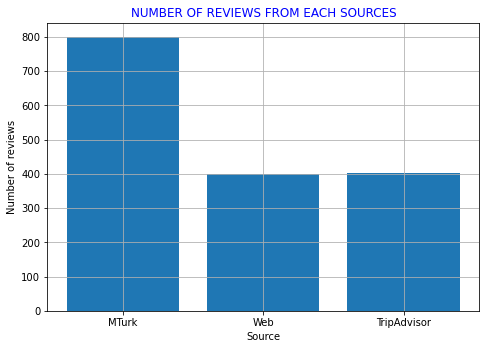

In [27]:
# Number of reviews from each source
def numberReviewsFromSources(sources):
    """
    numberReviewsFromSources 
        Plots the number of reviews from each source within the dataset

    Parameters
    ----------
    sources : pandas.core.series.Series
        Column in the DataFrame which contains the source
    """
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    rev = []
    name = []
    for source in sources.unique():
        sourcecount = sources.where(sources == source).count()
        print("The reviews from " + str(source), sourcecount)
        rev.append(sourcecount)
        name.append(source)
    ax.bar(name, rev)
    plt.title("Number of reviews from each sources".upper(), color="b")
    plt.ylabel("Number of reviews")
    plt.xlabel("Source")
    plt.grid()
    plt.show()
numberReviewsFromSources(d_copy[sources])

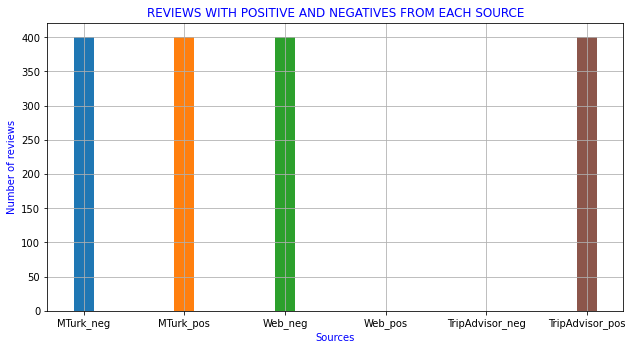

In [28]:
# Number of reviews with positive and negatives from each source
def numberReviewsFromSourcesPositiveNegatives():
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_axes([0,0,1,1])
    sor = d_copy[sources].unique()
    s = ["MTurk_neg", "MTurk_pos", "Web_neg", "Web_pos", "TripAdvisor_neg", "TripAdvisor_pos"]
    MTurk_neg = 0
    MTurk_pos = 0
    Web_neg = 0
    Web_pos = 0
    TripAdvisor_neg = 0
    TripAdvisor_pos = 0
    
    for i in range(len(d_copy)):
        if(d_copy[polarities][i] == "negative" and d_copy[sources][i] == sor[0]):
            MTurk_neg += 1
        elif(d_copy[polarities][i] == "positive" and d_copy[sources][i] == sor[0]):
            MTurk_pos += 1
        elif(d_copy[polarities][i] == "negative" and d_copy[sources][i] == sor[1]):
            Web_neg += 1
        elif(d_copy[polarities][i] == "positive" and d_copy[sources][i] == sor[1]):
            Web_pos += 1
        elif(d_copy[polarities][i] == "negative" and d_copy[sources][i] == sor[2]):
            TripAdvisor_neg += 1
        else:
            TripAdvisor_pos += 1
                
    ax.bar(s[0], MTurk_neg, width = 0.2)
    ax.bar(s[1], MTurk_pos, width = 0.2)
    ax.bar(s[2], Web_neg, width = 0.2)
    ax.bar(s[3], Web_pos, width = 0.2)
    ax.bar(s[4], TripAdvisor_neg, width = 0.2)
    ax.bar(s[5], TripAdvisor_pos, width = 0.2)
    plt.title("reviews with positive and negatives from each source".upper(), color="b")
    plt.ylabel("Number of reviews", color="b")
    plt.xlabel("Sources", color="b")
    plt.grid()
    plt.show()
            
numberReviewsFromSourcesPositiveNegatives()

#### Observation
<div class="alert alert-warning">
Here we can see that we don't have any positive review from web source and any negative review from TripAdvisor.
</div>

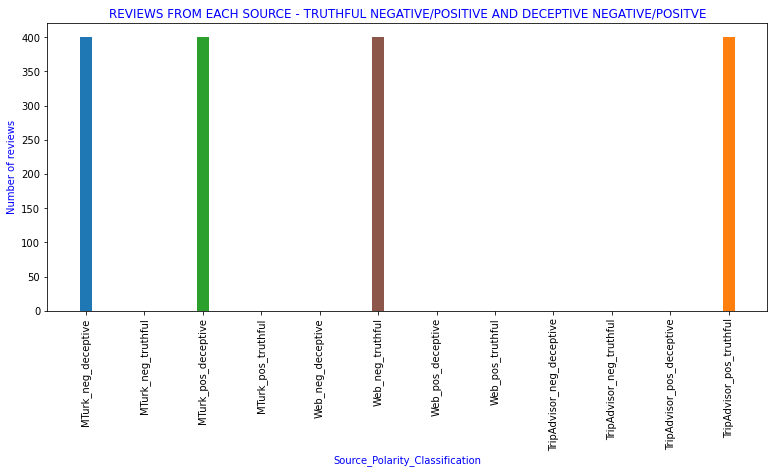

In [29]:
# The number of reviews from each source - truthful negative/positive and deceptive negative/positve

fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])
sorce = d_copy[sources].unique()
#'MTurk' 'Web' 'TripAdvisor'
pol = d_copy[polarities].unique()
# 'negative' 'positive'
clas = d_copy[classifications].unique()
# 'deceptive' 'truthful'
def Opinion():
    s = ["MTurk_neg", "MTurk_pos", "Web_neg", "Web_pos", "TripAdvisor_neg", "TripAdvisor_pos"]
    MTurk_neg_truthful = 0
    MTurk_neg_deceptive = 0
    MTurk_pos_truthful = 0
    MTurk_pos_deceptive = 0
    Web_neg_truthful = 0
    Web_neg_deceptive = 0
    Web_pos_truthful = 0
    Web_pos_deceptive = 0
    TripAdvisor_neg_truthful = 0
    TripAdvisor_neg_deceptive = 0
    TripAdvisor_pos_truthful = 0
    TripAdvisor_pos_deceptive = 0
    
    for i in range(len(d_copy)):
        if(d_copy[sources][i] == sorce[0] and d_copy[polarities][i]== pol[0] and d_copy[classifications][i]== clas[0]):
            MTurk_neg_deceptive += 1
        elif(d_copy[sources][i] == sorce[0] and d_copy[polarities][i]== pol[0] and d_copy[classifications][i]== clas[1]):
            MTurk_neg_truthful += 1
        elif(d_copy[sources][i] == sorce[0] and d_copy[polarities][i]== pol[1] and d_copy[classifications][i]== clas[0]):
            MTurk_pos_deceptive += 1
        elif(d_copy[sources][i] == sorce[0] and d_copy[polarities][i]== pol[1] and d_copy[classifications][i]== clas[1]):
            MTurk_pos_truthful += 1  
            
        elif(d_copy[sources][i] == sorce[1] and d_copy[polarities][i]== pol[0] and d_copy[classifications][i]== clas[0]):
            Web_neg_deceptive += 1
        elif(d_copy[sources][i] == sorce[1] and d_copy[polarities][i]== pol[0] and d_copy[classifications][i]== clas[1]):
            Web_neg_truthful += 1
        elif(d_copy[sources][i] == sorce[1] and d_copy[polarities][i]== pol[1] and d_copy[classifications][i]== clas[0]):
            Web_pos_deceptive += 1
        elif(d_copy[sources][i] == sorce[1] and d_copy[polarities][i]== pol[1] and d_copy[classifications][i]== clas[1]):
            Web_pos_truthful += 1
            
        elif(d_copy[sources][i] == sorce[2] and d_copy[polarities][i]== pol[0] and d_copy[classifications][i]== clas[0]):
            TripAdvisor_neg_deceptive += 1
        elif(d_copy[sources][i] == sorce[2] and d_copy[polarities][i]== pol[0] and d_copy[classifications][i]== clas[1]):
            TripAdvisor_neg_truthful += 1
        elif(d_copy[sources][i] == sorce[2] and d_copy[polarities][i]== pol[1] and d_copy[classifications][i]== clas[0]):
            TripAdvisor_pos_deceptive += 1
        else:
            TripAdvisor_pos_truthful += 1
            
    ax.bar("MTurk_neg_deceptive", MTurk_neg_deceptive, width = 0.2)
    ax.bar("MTurk_neg_truthful", MTurk_neg_truthful, width = 0.2)
    ax.bar("MTurk_pos_deceptive", MTurk_pos_deceptive, width = 0.2)
    ax.bar("MTurk_pos_truthful", MTurk_pos_truthful, width = 0.2)
    ax.bar("Web_neg_deceptive", Web_neg_deceptive, width = 0.2)
    ax.bar("Web_neg_truthful", Web_neg_truthful, width = 0.2)
    ax.bar("Web_pos_deceptive", Web_pos_deceptive, width = 0.2)
    ax.bar("Web_pos_truthful", Web_pos_truthful, width = 0.2)
    ax.bar("TripAdvisor_neg_deceptive", TripAdvisor_neg_deceptive, width = 0.2)
    ax.bar("TripAdvisor_neg_truthful", TripAdvisor_neg_truthful, width = 0.2)
    ax.bar("TripAdvisor_pos_deceptive", TripAdvisor_pos_deceptive, width = 0.2)
    ax.bar("TripAdvisor_pos_truthful", TripAdvisor_pos_truthful, width = 0.2)
    plt.xticks(rotation=90)
    plt.title("reviews from each source - truthful negative/positive and deceptive negative/positve".upper(), color="b")
    plt.ylabel("Number of reviews", color="b")
    plt.xlabel("Source_Polarity_Classification", color="b")
    plt.show()
            
Opinion()

#### Observation
<div class="alert alert-warning">
In the above bar-graph we have shown where exactly the deceptive and truthful originated from. The picture below summarises the data.
</div>

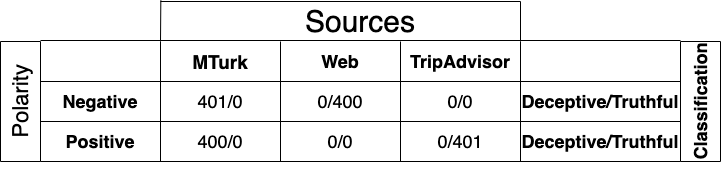

In [32]:
# for more descriptive how the number of reviews classified
Image(filename="T_D2.png", width=600, height=300)

In [33]:
#need to edit the image above
d_copy.groupby([sources,polarities,classifications]).size()

source       polarity  classification
MTurk        negative  deceptive         401
             positive  deceptive         400
TripAdvisor  positive  truthful          401
Web          negative  truthful          400
dtype: int64

In [34]:
# And the polarity given by the reviews provider
d_copy[reviews].value_counts().head()

The Omni was chosen for it's location whichworked out perfectly. The bedding was wondeful and everything seemed fairly clean ...until...I sat down in the tub...there was BLACK MOLD in the soap holder, in the cracks on the walls between the tile, all under the tile overhang above the tub and completely around the toilet bowl. Needless to say I drained the tub and took a shower...I really don't care for showers. Oh yes...the toilet leaked as well...The staff were very helpful but I was disappointed. I travel extensively and don't think I will return. we needed color copies for a business meeting and their printer was broken, so the man in the business center took the jump drive to another part of the hotel, printed the presentation and delivered it to our room. They try! We booked online for a weekend package and got a room on the 10th floor with a view of the windows of another building...but we weren't there too much.\n                                                                   

#### Observation
<div class="alert alert-warning">
From the above we can notice that there are four comments that are repeating. 
In order to clean the data we will remove these comments from the database.
</div>

## <u>Cleaning data</u>

First step of the cleaning process will be to remove line duplicate, we already found 4 lines that were duplicating during exploring the data step

In [35]:
d_copy = d_copy.drop_duplicates(keep = 'first',ignore_index = 'True')
d_copy.groupby([sources,polarities,classifications]).size()

source       polarity  classification
MTurk        negative  deceptive         401
             positive  deceptive         400
TripAdvisor  positive  truthful          401
Web          negative  truthful          400
dtype: int64

In [36]:
d_copy

,Unnamed: 0,classification,polarity,source,hotel,review
0,0,deceptive,negative,MTurk,talbott,The Talbott Hotel claims to be Chicago's Premi...
1,1,deceptive,negative,MTurk,talbott,I selected The Talbott for my recent family va...
2,2,deceptive,negative,MTurk,affinia,I recently stayed at the Affinia Hotel in Chic...
3,3,deceptive,negative,MTurk,hardrock,My husband and I stayed here at the Hard Rock ...
4,4,deceptive,negative,MTurk,hardrock,I stayed at the Hard Rock Hotel in Chicago rec...
...,...,...,...,...,...,...
1597,1597,truthful,positive,TripAdvisor,monaco,This is a great hotel! From the doorman who gr...
1598,1598,truthful,positive,TripAdvisor,james,I believe I can not describe how amazing was o...
1599,1599,truthful,positive,TripAdvisor,monaco,Stayed at the Monaco for a romantic weekend ge...
1600,1600,truthful,positive,TripAdvisor,monaco,Our room was on the third floor so there was s...


In [37]:
# alternatives to the 3 functions above

In [38]:
#s = d_copy.groupby([sources])[reviews].count()
#s.plot.bar(figsize=(8,4))
#plt.title("reviews with positive and negatives from each source".upper(), color="b")
#plt.ylabel("Number of reviews", color="b")
#plt.xlabel("Sources", color="b")
#plt.xticks(rotation=0)
#plt.show()
#
#d_copy.groupby([sources])[reviews].size()

In [39]:
#s = d_copy.groupby([sources,polarities])[reviews].count()
#s.plot.bar(figsize=(8,4),color = list('brgcmyk'),width = 0.2)
#plt.title("reviews with positive and negatives from each source".upper(), color="b")
#plt.ylabel("Number of reviews", color="b")
#plt.xlabel("Sources", color="b")
#plt.xticks(rotation=45)
#plt.show()

In [40]:
#s = d_copy.groupby([sources,polarities,classifications])[reviews].count()
#s.plot.bar(figsize=(8,4),color = list('brgcmyk'),width = 0.2)
#plt.title("reviews from each source - truthful negative/positive and deceptive negative/positve".upper(), color="b")
#plt.ylabel("Number of reviews", color="b")
#plt.xlabel("Source_Polarity_Classification", color="b")
#plt.xticks(rotation=45)
#plt.show()

<div class="alert alert-info">
    Lets now dig deeper into the data and the reviews:
</div>

* It may make sense to classify based on keywords pr ensemble of words, rather than sentence structure and other more complicated elements of the text data. To facilitate models's ability to recognize keywords, we will then clear the english-stopwords and numbers which are stored as a string.

Stop words are words that are common words that are considered neutral and do not add much meaning to the sentence. A default set of stop words (displayed in the cell above) are provided by The Natural Language Toolkit (NLTK). We used this set of words for processing and cleaning our data by filtring them out from all the comments. This will allow to decrease the number if feature and train more accurate model.

In [43]:
# stop-words we have in english
stop_words_list = []
# Assuming we only have english words in the reviews
stopwords = set(nltk_stop.words("english"))
for i in stopwords:
    stop_words_list.append(i)
print(f"we have {len(stop_words_list)} english-stopwords and some examples of them are:\n{stop_words_list[:20]}" )


we have 179 english-stopwords and some examples of them are:
['our', 'ma', 'all', 'what', 've', 'not', 'now', 'theirs', 'you', 'because', 'itself', 'him', 'been', 'through', 'too', 'out', 'when', 'your', 'between', 'ours']


#### Observation
<div class="alert alert-warning">
It is possible that some of these words, has some sentimental meaning and could be important for the classification of reviews. 
</div>

* Next, we will analyse more these words by counting how much they appear in truthful reviews and in deceptive reviews.

In [44]:
def stopWordsAnalysis(stopwords):
    n = len(stopwords)
    countwords_ = np.zeros((n,2))
    i = 0
    for word in stopwords:
        deceptive = 0
        truthful = 0
        tick = False
        for r in d_copy[reviews]:
            clas = d_copy[d_copy[reviews]==r].classification.values
            r = r.lower().split()
            for w in r:
                if (w == word):   # in d_copy[hotels].unique() or w == 'rock'):
                    tick = True
            if tick:
                tick = False
                if (clas.any() == 'deceptive'):
                    deceptive = deceptive + 1
                else:
                    truthful = truthful + 1
        countwords_[i, 0] = truthful 
        countwords_[i, 1] = deceptive
        i  = i + 1
    return countwords_
stopWordsCount = stopWordsAnalysis(stop_words_list)

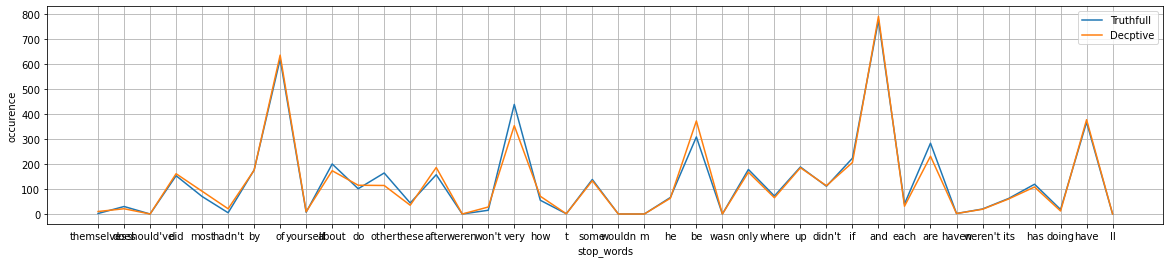

In [45]:
# We will plot some of the stop words occurences, but all the stop words were analysed,
fig = plt.figure(figsize=(20,4))
plt.plot (stop_words_list[120:160], stopWordsCount[120:160,0], label='Truthfull' )
plt.plot (stop_words_list[120:160], stopWordsCount[120:160,1], label='Decptive')
plt.xlabel('stop_words')
plt.ylabel('occurence')
plt.grid()
plt.legend()
plt.show()

#### Observation
<div class="alert alert-warning">
After analysing stop words we notice that generally these stop words has neutral feeling (ex: 'and' used around 800 times in truthfull as well as Deceptive reviews). However we find some words that could be used for the classification. Example here: "I, me, my" tend to appear more in deceptive review, while "we, our" tend to be more present in truthfull reviews. May, be false poeple writing deceptive review consider that they did visit the hotel alone (as they are writing the review alone, so they do not consider that they visit with their family so they tend to use I), while real poeple really visiting as family or couple would tend to say we. So, these words should be removed from the stop_word list as they would be important for the classification
</div>

* Another cleaning step that we did consider is checking how the presence of the hotel name is affecting the review

In [49]:
def reviewWithOutHotelName():
    count = 0
    tick = False
    truthful = 0
    deceptive = 0
    for r in d_copy[reviews]:
        clas = d_copy[d_copy[reviews]==r].classification.values
        r = r.lower().split()
        for w in r:
            if (w in d_copy[hotels].unique() or w == 'rock'):
                tick = True
        if tick:
            count += 1
            tick = False
        else:
            if (clas.any() == 'deceptive'):
                deceptive = deceptive + 1
            else:
                truthful = truthful + 1
    print("Reviews without the name of hotel: ",len(d_copy[reviews]) - count)
    print("number of deceptive: ",deceptive)
    print("number of truthful: ",truthful)
reviewWithOutHotelName()

Reviews without the name of hotel:  622
number of deceptive:  194
number of truthful:  428


#### Observation
<div class="alert alert-warning">
The review without hotel name tend to be truthful, more than deceptive. May be the poeple writing deceptive review tend to write again the hotel name may be because their purpose is the hotel reputation, they tend to emphasize on hotel name and this could allow them also to have better ranking of their review when google searching of hotel name. While other poeple, writing truthfull review, their purpose is just to share their feelings and experience. So, we will consider next the name of the hotels in the review as a single word 'hotelname'. Beacause, the hotel names has a similar meaning and we see that they could be important for the ranking
</div>

* So, next, in addition to removing the selected stopwords and numbers from all the reviews, to clean the data for the training, we will also consider changing the hotel name in the reviews to the word 'hotelname', to group all hotel names one single feature because it would have same meaning in all the reviews. 

In [50]:
new_stopWords = [word for word in stop_words_list if word not in ['i', 'me', 'my', 'we', 'our','ours', 'on', 'but', 
                                                                        'themselves', 'very',"hadn't",'while','will','other',"you'd",'through']]

In [51]:
def removeStopwordsPuctuationAln(review_column,stopWords,language="english"):
    """
    remove_stopwords_special_char 
        Makes the reviews lower case,
        removes puncutation, diaeresis, numbers and other special characters,
        as well as removing stopwords using the default nltk_stop words

    Parameters
    ----------
    review_column : pandas.core.series.Series
        Column in the DataFrame which contains the reviews
    language : str, optional
        language of stopwords, by default "english"

    Returns
    -------
    list(str)
        Returns the cleaned reviews as a list
    """
    cleaned_reviews = []
    alphabetic = re.compile(r"[^a-zA-Z\s]") #finds characters not in the range: a-zA-Z and whitespace and '
    singlequote = re.compile(r"((\W)(?:\B|$)|(?:^|\B)(\W))") #finds single quotes not within a word
    for review in review_column:
        new_words = []
        review = unidecode(review) #example: ãБç becomes abc
        review = re.sub(alphabetic," ",review) #example: 2"3can't"/ becomes can't
        review = re.sub(singlequote," ",review) #example: ''' shouldn't '''''' becomes shouldn't
        words = review.lower().split()
        for word in words:
            if(not (word in stopwords) and (word.strip()) and len(word)>1):
                new_words.append(word)
            if( (word in d_copy[hotels].unique()) and (word.strip()) and len(word)>1):
                new_words.append('hotelname')
            else:
                continue
        cleaned_reviews.append(" ".join(new_words))
    return cleaned_reviews

clean_review = removeStopwordsPuctuationAln(d_copy[reviews],new_stopWords)

In [52]:
len(clean_review)

1602

* We can see the difference on number of all words in reviews before and after the stopwords cleared out.

In [53]:
sum_orginal = 0
sum_cleaned = 0
for i in range(len(d_copy)):
    sum_orginal += len(d_copy[reviews][i].split(" "))
    sum_cleaned += len(clean_review[i].split(" "))
print("*"*100)
print("Original words: ", sum_orginal)
print("Without stopwords & alnum: ", sum_cleaned)
print("Difference : ", sum_orginal - sum_cleaned)

****************************************************************************************************
Original words:  238967
Without stopwords & alnum:  117365
Difference :  121602


* By using wordcloud we can visualize the most common words from the reviews

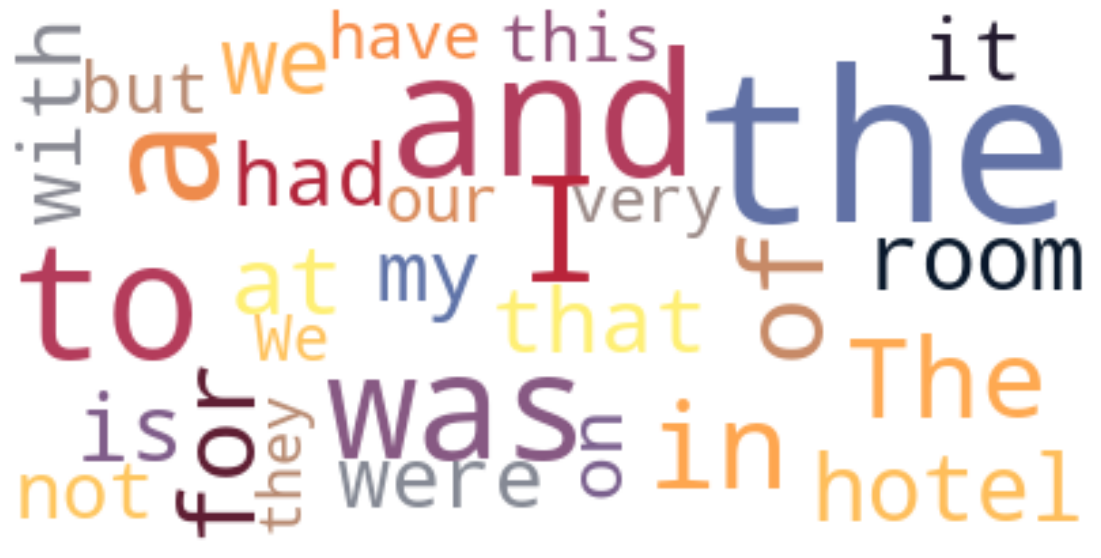

In [ ]:
#original reviews

hero.visualization.wordcloud(d_copy['review'], max_words=30,background_color='white')

#### Observation
<div class="alert alert-warning">
The wordcloud above shows that the most common word is "the" without cleaning the dataset
</div>

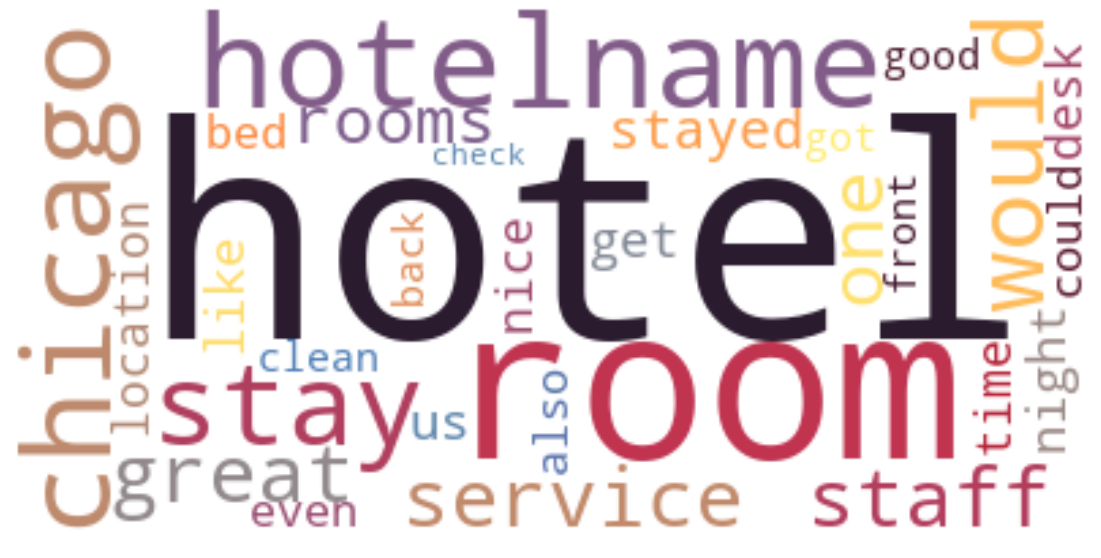

In [ ]:
#reviews without stopwords
hero.visualization.wordcloud(pd.Series(clean_review), max_words=30,background_color='white')

#### Observation
<div class="alert alert-warning">
After removing the stopwords the word "hotel" becomes the most common word
</div>

* Another important processing step is to group the words having same root into one feature. This is called stemming or Text Normalization and this is a common technic used in NLP. In fact, these words having same root will have similar meaning. So, grouping them in one feature would make more robust model, specially as we have a small data base, so we need fewer number of features. This was done also using the NLTK library and we choosed Porter method....

In [54]:
def stemReviews(nnStem_reviews):
    """
    stemSentence 
        Using the default nltk Porter Stemmer for text normalization

    Parameters
    ----------
    nnStem_reviews : list(str)
        List of reviews

    Returns
    -------
    list(str)
        returns the reviews after stemming
    """
    cleaned_reviews = []
    porter=PorterStemmer()
    for review in nnStem_reviews:
        token_words=word_tokenize(review)
        stem_sentence=[]
        for word in token_words:
            stem_sentence.append(porter.stem(word))
        cleaned_reviews.append(" ".join(stem_sentence))
    return cleaned_reviews

stem_review = stemReviews(clean_review)


* We can see the difference of number of all words in reviews after removing stop words and after stemming

In [55]:
#print(clean_review[0])
#print(reviews_text[0])
vectorizer = CountVectorizer() 
review_words = vectorizer.fit_transform(clean_review)
print('Number of words in the review after removing stop words and before stemming is : ', review_words.shape[1])
#print(vectorizer.vocabulary_)
#print('*'*100)
clean_review_words = vectorizer.fit_transform(stem_review)
print('Number of words in the clean review after stemming is :', clean_review_words.shape[1])
#print(vectorizer.vocabulary_)
print('*'*100)
print('Number of features decreased by ', 100*(review_words.shape[1]-clean_review_words.shape[1])/review_words.shape[1], '%' )

Number of words in the review after removing stop words and before stemming is :  9147
Number of words in the clean review after stemming is : 6381
****************************************************************************************************
Number of features decreased by  30.23942276156117 %


#### Observation
<div class="alert alert-warning">
We see a decrease of 30% in number of features. This is quite important result specially as the data set is small to avoid over fitting. In fact, stemming allows to group similar words having similar root and thus generally similar meaning allowing to generate less correlable features.
</div>


* top 15 words before and after stemming

In [ ]:
hero.top_words(pd.Series(clean_review))[:20]

hotel        3333
room         2813
hotelname    1636
chicago      1524
stay         1302
would         922
great         864
staff         836
service       815
one           717
rooms         679
stayed        664
us            575
night         574
like          557
get           551
time          522
desk          508
nice          489
location      482
dtype: int64

In [ ]:
hero.top_words(pd.Series(stem_review))[:20]

hotel       3642
room        3494
stay        2261
hotelnam    1636
chicago     1524
would        922
servic       871
great        866
staff        838
night        764
one          733
bed          688
get          636
time         630
locat        623
check        617
like         614
us           575
clean        546
even         522
dtype: int64

#### Observation
<div class="alert alert-warning">
We can notice that stay was ranked 4th before stemming and moved to the 3rd place. Similarly servic moved root of service moved from 8 to 6. However, we notice that sometimes the stemming do not generate real words or could mix some words with similar root. This is an uncertainty that we will accept as we think it will not have a very big impact on results (actually we compared the results with stemming and without and we found we have slightly better result with stemming.
</div>

We implemented also in the next cell, ngramfeatures function which allows to use more than one word as a feature by grouping subsequent words.

Later on, We used the embedded ngram prameter in the sklearn countvectorizer class to simplify the coding


#### <u>Two classes</u>
These classes makes the process formal both for the input as text and output which is the result as a truthful or deceptive.


In [72]:
class Classifier:
    """
     Something about the Classifier class
    """
    Truthful = "truthful".upper()
    Falseful = "deceptive".upper()
class Re:
    """
     Something about the review class
    """
    def __init__(self, classification, polarity, source, hotel, review):
        """
        __init__ 
            Initializing the class object

        Parameters
        ----------
        classification : str
            Classification of the review, either deceptive or thruthful
        polarity : str
            If the review is positive or negative
        source : str
            Where the review was posted
        hotel : str
            The hotel which the review is for
        review : str
            The review
        """
        self.classification = classification
        self.polarity = polarity
        self.source = source
        self.hotel = hotel
        self.review = review
        self.result = self.geter()
        
    def geter(self):
        """
        geter 
            Something about geter function

        Returns
        -------
        Classifier
        """
        if(self.classification == "deceptive" and (self.polarity == "negative" or self.polarity == "positive")):
            return Classifier.Falseful
        if(self.classification == "truthful" and(self.polarity == "negative" or self.polarity == "positive")):
            return Classifier.Truthful
        
        

In [73]:
rs = []
for i in range(len(d_copy)):
    rs.append(Re(d_copy["classification"][i], d_copy["polarity"][i],
                 d_copy["source"][i], d_copy["hotel"][i], stem_review[i]))

The classical approach and the deep learnign approach do need different way of features engineering. In this regards, now, we will divide our work in two parts Classical approach and deep learning

# <u> Classical approach </u>


## <u>Feature selection & Engineering,</u>


* Another thing we want to mention is that there are several reviews without including a name of any hotel in them, that might have some influence on training the models we are going to use. To point out on how many of them, we have <code>reviewWithOutHotelName</code> function:

In [58]:
def ngramfeatures(ng_reviews, n=3):
  text = []
  for rev in ng_reviews:
        text.append(rev)
  # first get individual words
  tokenized = str(text).split() 
  # get a list of all the bi-grams
  nGrams = ngrams(tokenized, n) 
  return list(nGrams)
    
features = ngramfeatures(clean_review,3)
print (len(list(features)))
print ((features)[:15])


117363
[("['talbott", 'hotelname', 'hotel'), ('hotelname', 'hotel', 'claims'), ('hotel', 'claims', 'chicago'), ('claims', 'chicago', 'premiere'), ('chicago', 'premiere', 'small'), ('premiere', 'small', 'luxury'), ('small', 'luxury', 'hotel'), ('luxury', 'hotel', 'staying'), ('hotel', 'staying', 'experiencing'), ('staying', 'experiencing', 'service'), ('experiencing', 'service', 'environment'), ('service', 'environment', 'hotel'), ('environment', 'hotel', 'general'), ('hotel', 'general', 'say'), ('general', 'say', 'confidence')]


* Lets began with 70% of data for training and the rest for testing.

In [74]:
training, test = train_test_split(rs, test_size=0.3, random_state=42)
print("Number of reviews used for training:", len(training))
print("Number of reviews used for testing:",len(test))


Number of reviews used for training: 1121
Number of reviews used for testing: 481


In [75]:
train_x = [x.review for x in training]
train_y = [x.result for x in training]

test_x = [x.review for x in test]
test_y = [x.result for x in test]


#### Vectorization with ngram

* Models we are going to use do not accept plain text as input and only work with numbers. Therefore, we had to find a method to represent the reviews as numbers, more specifically as vectors or matrices. There are several ways to do this, but we have mainly used countervectorizer in scikit-learn implementation. <code>We will also show the use "tf-idf"</code>, which is another type of wordembedding which is also more popular on some of the models we will pick up.Tf-idf stands for term frequency - inverse document frequency. The algorithm calculates first out a word frequency, "tf", for each word in a review and then weight this frequency with a number based on how often the word occurs over all the reviews, "idf". The word frequency is just the ratio between the number of occurrences of a word in a review and the total number of words in the same review. The inverse document frequency for one word is the logarithm of the ratio between the number of reviews and the number of reviews that contain the word. The word frequency is weighted by document frequency by multiplying the two numbers together. What we end up with is a number that says how much a word has been used in a text, relative to how often the word is used in all the reviews.

In [4]:
vectorizer = CountVectorizer(ngram_range=(1, 2))    #  Apply ngram _1 to 2 words
train_x_vectors = vectorizer.fit_transform(train_x)
test_x_vectors = vectorizer.transform(test_x) # here we don't need to fit, cause it is a test data
print(train_x_vectors.shape)
print(vectorizer.get_feature_names()[1050:1100])

NameError: name 'train_x' is not defined

<div class="alert alert-warning">
Should mention ngram before it's used
</div>

## <u>Classification - testing models</u>

### <u> 1. MODEL: SVM (sklearn) </u>

In [69]:
# fiting and predicting svm & prints some sampls, both for the true solution and the predicted ones
clf_svm = svm.SVC(kernel="linear")
clf_svm.fit(train_x_vectors, train_y)

for i in range(10):
    print("True solution from dataset: ", test_y[i])
    print("Learned svm: ", clf_svm.predict(test_x_vectors[i])[0])
    print("*"*15)

True solution from dataset:  TRUTHFUL
Learned svm:  DECEPTIVE
***************
True solution from dataset:  DECEPTIVE
Learned svm:  DECEPTIVE
***************
True solution from dataset:  DECEPTIVE
Learned svm:  DECEPTIVE
***************
True solution from dataset:  DECEPTIVE
Learned svm:  TRUTHFUL
***************
True solution from dataset:  TRUTHFUL
Learned svm:  TRUTHFUL
***************
True solution from dataset:  TRUTHFUL
Learned svm:  TRUTHFUL
***************
True solution from dataset:  DECEPTIVE
Learned svm:  TRUTHFUL
***************
True solution from dataset:  DECEPTIVE
Learned svm:  DECEPTIVE
***************
True solution from dataset:  DECEPTIVE
Learned svm:  DECEPTIVE
***************
True solution from dataset:  TRUTHFUL
Learned svm:  TRUTHFUL
***************


In [78]:
# and see the score of this model
print(clf_svm.score(test_x_vectors, test_y))

0.8586278586278586


In [79]:
print(clf_svm.score(train_x_vectors, train_y))

0.9901873327386262


* let's try for better by working on hyperparameter tuning of this model

In [80]:
# we start by using standardscaler
clf_svm = svm.SVC(gamma="scale")
clf_svm.fit(train_x_vectors, train_y)

print(clf_svm.score(test_x_vectors, test_y))

0.8586278586278586


#### Parameters tuning and precision (GridSearch)

* Now lets take use of greadsearch by cross-validation to find a better result.

In [81]:
def testingForGridSearchForSVM():    
    print(__doc__)

    # Set the parameters by cross-validation
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3],
                         'C': [10, 100, 1000, 10000]},
                        {'kernel': ['linear'], 'C': [0.001, 0.1, 1, 10]}]
    scores = ['precision', 'recall']

    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()
        clf = GridSearchCV(
            SVC(), tuned_parameters, scoring = "%s_macro" % score
        )
        clf.fit(train_x_vectors, train_y)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = test_y, clf.predict(test_x_vectors)
        print(classification_report(y_true, y_pred))
        print()
testingForGridSearchForSVM()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.807 (+/-0.028) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.856 (+/-0.037) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.807 (+/-0.028) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.854 (+/-0.024) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.807 (+/-0.028) for {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
0.854 (+/-0.024) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.807 (+/-0.028) for {'C': 10000, 'gamma': 0.01, 'kernel': 'rbf'}
0.854 (+/-0.024) for {'C': 10000, 'gamma': 0.001, 'kernel': 'rbf'}
0.786 (+/-0.067) for {'C': 0.001, 'kernel': 'linear'}
0.844 (+/-0.015) for {'C': 0.1, 'kernel': 'linear'}
0.844 (+/-0.015) for {'C': 1, 'kernel': 'linear'}
0.844 (+/-0.015) for {'C': 10, 'kernel': 'linear'}

Detailed classification report:

The model

#### Observation
<div class="alert alert-warning">
Here, we have an example of the best parameters would use to come up to 88/89% accuracy. And this accuracy is ok since we have very small data to train the model.
</div>

### <u> 2. MODEL: Decision Tree  (sklearn) </u>

In [88]:
clf_dec = DecisionTreeClassifier()
clf_dec.fit(train_x_vectors, train_y)

DecisionTreeClassifier()

In [89]:
# See simple result
for i in range(3): 
    print("Predicted solution: ",clf_dec.predict(test_x_vectors[i]))
    print("True solution: ", test_y[i])

Predicted solution:  ['DECEPTIVE']
True solution:  TRUTHFUL
Predicted solution:  ['DECEPTIVE']
True solution:  DECEPTIVE
Predicted solution:  ['DECEPTIVE']
True solution:  DECEPTIVE


In [90]:
clf_dec_score = clf_dec.score(test_x_vectors, test_y)
print(clf_dec_score)

0.7338877338877339


#### Observation
<div class="alert alert-warning">
In decisionTree we have not performed a gridsearch. The reason is, that we saw the probability of this model giving us better results than the svm-model results is very low, since we only got 69% at this level and the fact that we have very limted data. Thus, the decision-tree-classifier can not compare to svm.
</div>

### <u> 3. MODEL: Logistic Regression (sklearn) </u>

LogisticRegression is mostly used for data processing that has two fall options, for example 0 or 1 similar. It has been chosen to look more closely at this model, which could have been turned into truthful/falsful. Lets see the results for accuracy and time for this model:

In [162]:

clf_lg = LogisticRegression()
clf_lg.fit(train_x_vectors, train_y)
clf_lg_score = clf_lg.score(test_x_vectors, test_y)
print(clf_lg_score)
%timeit clf_lg

0.8794178794178794
26.9 ns ± 1.56 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


#### Parameters tuning and precision (GridSearch)

* In the above we see that the logistic regression from sklearn with about 90% accuracy, but lets if the model can do better by use of gridsearch...

In [92]:
# example of grid searching key hyperparametres for logistic regression

def testingForGridsLG():
    
    # define models and parameters
    model = LogisticRegression()
    solvers = ["newton-cg", "lbfgs", "liblinear"]
    penalty = ["l2"]
    c_values = [100, 10, 1.0, 1e-1, 1e-2]
    
    # define grid search
    grid = dict(solver = solvers, penalty = penalty, C = c_values)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
    grid_result = grid_search.fit(train_x_vectors, train_y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
        y_true, y_pred = test_y, grid_search.predict(test_x_vectors)
    print("*"*77)
    print(classification_report(y_true, y_pred))

testingForGridsLG()

Best: 0.859084 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.855810 (0.034371) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.856108 (0.034728) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.855515 (0.034071) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.856998 (0.034795) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.856998 (0.034795) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.857893 (0.033959) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.857888 (0.033437) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.857888 (0.033437) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.859084 (0.034296) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.857593 (0.033226) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.857593 (0.033226) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.857888 (0.032706) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.840345 (0.035684) wit

#### Observation
<div class="alert alert-warning">
We see that the accuracy we are getting is lower than the previous one which is tested by the use of default parameters. In here, we see that we can get the minimum accuracy(assuming with the use of the parameters from <code>testingForGridsLG</code>) but the maximum can be 90 or greater. So the model is comparable with other good models..
</div>

### <u> 4. MODEL: Naive_bayes (sklearn) </u>

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf_gnb = GaussianNB()
y_pred = clf_gnb.fit(train_x_vectors.toarray(), train_y)
clf_gnb_score = clf_gnb.score(test_x_vectors.toarray(), test_y)
print(clf_gnb_score)

0.778705636743215


#### Observation
<div class="alert alert-warning">
In Naive_bayes, we have not performed a gridsearch. The reason is, that we saw the probability of this model giving us better results than the svm-model results is very low, since we only got 77% at this level and the fact that we have very limted data. Thus, the decision-tree-classifier can not compare to svm.
</div>

## <u>A couple model, one from sklearn and one from keras using TF-IDF</u>


<div class="alert alert-info"> Logistic reg with concern of vocublary and use of tfidf</div

In [107]:
count = CountVectorizer()
docs = ([d_copy[reviews][10]])
bag = count.fit_transform(docs)
print(docs)
print("*"*100)
print(count.vocabulary_)
print(bag.toarray())

["The Ambassador East Hotel is a terrible place to stay. All of the rooms are old and dirty as though they haven't been cleaned or remodeled for years. The hotel staff is not friendly or accomodating. Do not waste your money in this crappy old hotel full of rude employees.\n"]
****************************************************************************************************
{'the': 32, 'ambassador': 2, 'east': 11, 'hotel': 17, 'is': 19, 'terrible': 31, 'place': 25, 'to': 36, 'stay': 30, 'all': 1, 'of': 22, 'rooms': 27, 'are': 4, 'old': 23, 'and': 3, 'dirty': 9, 'as': 5, 'though': 35, 'they': 33, 'haven': 16, 'been': 6, 'cleaned': 7, 'or': 24, 'remodeled': 26, 'for': 13, 'years': 38, 'staff': 29, 'not': 21, 'friendly': 14, 'accomodating': 0, 'do': 10, 'waste': 37, 'your': 39, 'money': 20, 'in': 18, 'this': 34, 'crappy': 8, 'full': 15, 'rude': 28, 'employees': 12}
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 2 1 2 2 2 2 1 1 1 1 1 1 1 3 1 1 1
  1 1 1 1]]


In [ ]:
np.set_printoptions(precision=2)
tfidf = TfidfTransformer(use_idf=True, norm="l2", smooth_idf=True)
print(tfidf.fit_transform(bag).toarray())

[[0.06 0.12 0.18 0.06 0.23 0.06 0.06 0.06 0.12 0.06 0.06 0.06 0.06 0.06
  0.12 0.06 0.12 0.06 0.06 0.06 0.06 0.06 0.06 0.12 0.06 0.06 0.06 0.06
  0.06 0.06 0.06 0.12 0.06 0.06 0.12 0.06 0.06 0.12 0.06 0.06 0.06 0.06
  0.06 0.23 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.23
  0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.12 0.06 0.65 0.12
  0.06 0.06 0.06 0.06 0.12 0.06 0.12 0.12]]


#### Data Preparation: Preprocessing

In [117]:
def preprocessor(rev):
    rev =re.sub("<[^>]*>", "", rev)
    emoticons = re.findall("(?::|;|=)(?:-)?(?:\)|\(|D|P)", rev)
    rev = re.sub("[\W]+", " ", rev.lower()) + " ".join(emoticons).replace("-", "")    
    return rev
#preprocessor(d_copy[reviews][0])

#### Toknization

In [118]:
porter = PorterStemmer()
def tokenizer(text):
    return text.split()
#print(tokenizer(d_copy[reviews][0]))

In [119]:
def tokenizer_stemmer(text):
    return[porter.stem(word) for word in text.split()]

#print(tokenizer_stemmer(d_copy[reviews][0]))

#### Transform Text Data into TF-IDF Vectors

In [120]:

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=True,
                        preprocessor=preprocessor, # defined preprocessor in Data Cleaningtokenizer=tokenizer_stemmer,
                        use_idf=True,
                        norm="l2",
                        smooth_idf=True)

In [121]:
#d_copy[reviews][:]
#d_copy[classifications][:]
# We don't need to use this for-loops
sen = []
for i in d_copy[classifications][:]:
    if(i == "deceptive"):
        i = "0"
        i = int(i)
        sen.append(i)
    else:
        i = "1"
        i = int(i)
        sen.append(i)
len(sen)

1602

### <u> 5. MODEL: Logistic RegressionCV (sklearn) </u>

In [134]:
y = sen # the same as d_copy[classifications][:]
X = tfidf.fit_transform(d_copy[reviews][:])
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
X_train, X_test, y_train, y_test = train_test_split(X, d_copy[classifications][:], random_state=42, test_size=0.3, shuffle=True)

clf = LogisticRegressionCV(cv=5,
                           scoring="accuracy",
                           random_state=0,
                           n_jobs=-1,
                           verbose=3,
                           max_iter=300)
clf.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.8s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.9s finished


LogisticRegressionCV(cv=5, max_iter=300, n_jobs=-1, random_state=0,
                     scoring='accuracy', verbose=3)

In [135]:
clf.score(X_test, y_test)

0.8752598752598753

In [136]:
# Testing our model write some observation comparing to the first logistic-regration
for i in range(5):
    x = d_copy[reviews][i] # "This is a worsest movie"
    x = tfidf.transform([x])
    print(clf.predict(x))

['deceptive']
['deceptive']
['deceptive']
['deceptive']
['deceptive']


In [137]:
clf_lg = LogisticRegression()
clf_lg.fit(X_test, y_test)
clf_lg_score = clf_lg.score(X_test, y_test)
print(clf_lg_score)

0.9875259875259875



#### Observation
<div class="alert alert-warning">
We see if we would have used the original data with model 3(which is LogisticRegression without cross validation and cleaned data) the result is almost 99%. But when it comes to LogisticRegressionCV we see the result decreased to 85. 
</div>

### <u> 6. MODEL: MLP from (keras) </u>

We have also tested mlp from keras and this type of machine learning method is an artificial neural networks and uses a multilayer-perceptron model, one of the simplest types among such networks. An artificial neuron, also called a perceptron, is a unit or analytical function that can receive any number of numeric inputs, and provides one numeric output.

Our mlp model consists of an input layer, a hidden layer and an output layer. The input layer is a layer without weights with as many neurons as there are elements in the text vectors. In the hidden layer, we have experimented with different numbers of neurons, through testing(for.example 10, 100, 150, 300) we concluded that 250 neurons give good results. The output layer consists of one neuron, for truthful/deceptive. We only use one hidden layer because we do not have enough data to train a more complicated model.

In the hidden layer, the neurons have ReLU as activation function and the output layer has sigmoid as activation function. ReLU is recognized as both effective and useful for learning in neural networks. We use binary crossentropy as the loss function and the loss function must be derivable with regard to the activation functions in the network to enable learning. As an optimization function, we used a modern and recognized version of backpropagation(algorithm for optimizing artificial neural networks), called Adamax.

TidfVectorizer gives us the ability to look at occurrences of sequences of two or more words. This can be interesting because certain word pairs or longer sequences can describe something completely unique and differ from cases where the words are used separately over an entire reviews. Each such sequence is considered a unique word and longer sequences can lead to large numbers of vocabulary and thus the length of the vectors. Then vectors for our dataset have become several thousands elements long and this could lead to a long driving time for training the model if we had good enough data. For our learning purpose, we assumed that we have enough data and used another class from Scikit-Learn's feature extraction module called, SelectKBest. It allows us to build a new vocabulary, of a given size, which consists of the words that best represent. This is done through the class "fit" method and then we minimize the vectors through the class' "transform" method. This could have helped to reduce run time, without having a major impact on the model's accuracy, again if we would have a large data. We point out this for quality reasons and assuming the model would have been distributed in the cloud and serve for a large amount of data

To implement the model, we have used the TythorFlow python library:

In [38]:
d_copy.columns

Index(['Unnamed: 0', 'classification', 'polarity', 'source', 'hotel',
       'review'],
      dtype='object')

In [39]:
print(type(d_copy[classifications]))
print(type(d_copy[reviews]))
type(d_copy)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


pandas.core.frame.DataFrame

In [40]:
import sys
d2 = []
for i in range(len(d_copy[classifications])):
    if (d_copy[classifications][i] == "deceptive"):
        x = 0
        d2.append([x, d_copy[reviews][i]])
    elif(d_copy[classifications][i] == "truthful"):
        x = 1
        d2.append([x, d_copy[reviews][i]])
        

In [41]:
df2 = pd.DataFrame(d2, columns=['label','review'])

In [42]:
len(df2["review"])

1602

In [106]:
# Split lists into training and validation data:
train_texts, val_texts, train_labels, val_labels = train_test_split(df2["review"], df2["label"], test_size=0.3,
                                                                    random_state=42)
# Convert label-lists to numpy for compatibility with keras:
train_labels, val_labels = np.array(train_labels), np.array(val_labels)
print(len(train_texts))
print(train_labels)
print(len(val_texts))
print(len(val_labels))


1121
[0 1 1 ... 0 1 0]
481
481
481


In [112]:
vectorizer = TfidfVectorizer(ngram_range = (1, 3), dtype = np.float32,analyzer = "word", min_df = 2)

# Learn vocabulary training texts.
x_train = vectorizer.fit_transform(train_texts)

# Vectorize validation texts.
x_val = vectorizer.transform(val_texts)

x_train.shape

(1121, 33082)

In [113]:
# Select top 'k' of the vectorized features.
selector = SelectKBest(f_classif, k="all")

# Transform x_train and x_val with top 'k' features and convert to numpy:
x_train = selector.fit_transform(x_train, train_labels).astype("float32").toarray()
x_val = selector.transform(x_val).astype("float32").toarray()


In [114]:
# Create a multilayer-perceptron model:

model = models.Sequential()

# Input layer and first hidden layer:
model.add(Dense(units=250, input_shape=x_train.shape[1:], activation="relu"))
# Dropout layer to help prevent overfitting:
model.add(Dropout(rate=0.2))
# Output layer:
model.add(Dense(units=1, activation="sigmoid")) #softmax

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 250)               8270750   
_________________________________________________________________
dropout_4 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 251       
Total params: 8,271,001
Trainable params: 8,271,001
Non-trainable params: 0
_________________________________________________________________


In [115]:

# This is used to make the model more likely to guess that a sample belongs to an underrepresented label.
#class_weight = class_weight.compute_class_weight("balanced", np.unique(train_labels), train_labels)

# Set final hyperparamaters:
learning_rate=1e-3
epochs=6
batch_size=128
loss = "binary_crossentropy"
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

model.compile(optimizer=optimizer, loss=loss, metrics=["acc"])

# Create callback for early stopping on validation loss. If the loss does
# not decrease in two consecutive tries, stop training.
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=2)]

# Train and validate model.
history = model.fit(
        x_train,
        train_labels,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=(x_val, val_labels),
        verbose=2,  # Logs once per epoch.
        #class_weight=class_weight,
        batch_size=batch_size)

# Print results.
history = history.history

print("Validation accuracy: {acc}, loss: {loss}".format(acc=history["val_acc"][-1], loss=history["val_loss"][-1]))


Train on 1121 samples, validate on 481 samples
Epoch 1/6
1121/1121 - 2s - loss: 0.6793 - acc: 0.7779 - val_loss: 0.6435 - val_acc: 0.8794
Epoch 2/6
1121/1121 - 1s - loss: 0.5531 - acc: 0.9866 - val_loss: 0.5669 - val_acc: 0.8960
Epoch 3/6
1121/1121 - 1s - loss: 0.4030 - acc: 0.9964 - val_loss: 0.4908 - val_acc: 0.9148
Epoch 4/6
1121/1121 - 1s - loss: 0.2715 - acc: 1.0000 - val_loss: 0.4258 - val_acc: 0.9023
Epoch 5/6
1121/1121 - 1s - loss: 0.1751 - acc: 1.0000 - val_loss: 0.3746 - val_acc: 0.9044
Epoch 6/6
1121/1121 - 1s - loss: 0.1117 - acc: 1.0000 - val_loss: 0.3380 - val_acc: 0.9044
Validation accuracy: 0.9043658971786499, loss: 0.3380295098323584


In [116]:
predictions = model.predict(x_val)
pred_labels = [np.argmax(pred) for pred in predictions]
print(classification_report(val_labels, pred_labels, zero_division=1))

              precision    recall  f1-score   support

           0       0.51      1.00      0.67       244
           1       1.00      0.00      0.00       237

    accuracy                           0.51       481
   macro avg       0.75      0.50      0.34       481
weighted avg       0.75      0.51      0.34       481



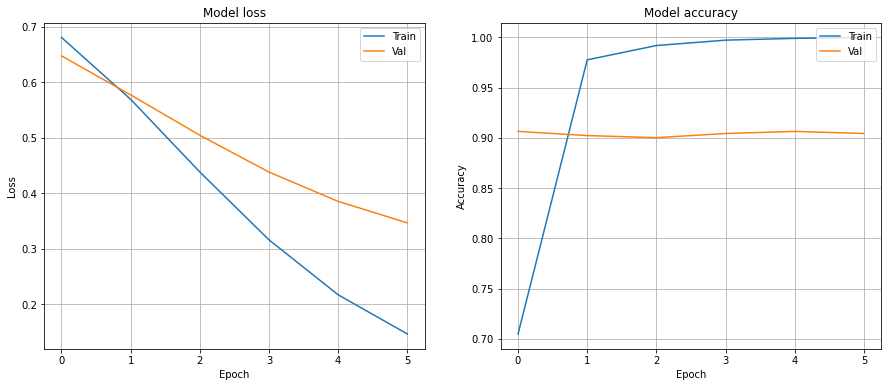

In [72]:
fig = plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.grid()

plt.subplot(1,2,2)
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.grid()
plt.show()

### Overfitting

It is difficult to see that the model is exposed to an effect called "overfitting" due to lack of data, and the figure does not give a stable result every time it runs. By "overfitting" we mean that the model is adapting to the training data so much that it is getting worse on recognizing other data. The graph to the left shows the result of the loss function over training epochs. 

On the right side the accuracy from the first six epochs is shown. Here, the trained and validated data diverge. Even the results show a clear accuracy of about 87 percent, it is uncertain whether the model will be able to maintain the same accuracy for the remaining. And this is as a control check to assess whether the figure on the left side is correct or not. We do this to see if the model actually improves.

We have also checked the classification report, it seems very unstable the way the model trained for some reason.

In [118]:
y_pred = model.predict(x_val)
y_pred = [[1.0 if n > 0.1 else 0.0 for n in row] for row in y_pred]

print(classification_report(val_labels, y_pred, target_names=None))
conf = multilabel_confusion_matrix(val_labels, y_pred)


              precision    recall  f1-score   support

           0       1.00      0.11      0.20       244
           1       0.52      1.00      0.69       237

    accuracy                           0.55       481
   macro avg       0.76      0.56      0.44       481
weighted avg       0.76      0.55      0.44       481



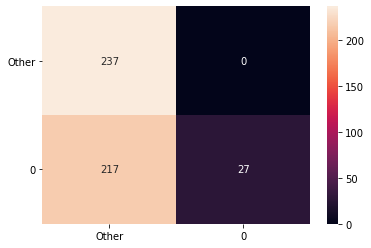

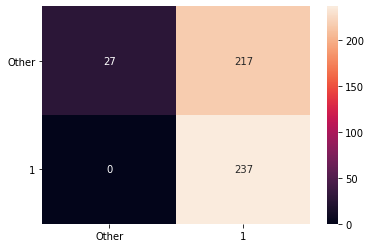

In [121]:
for i, matrix in enumerate(conf):
    tick_labels = ['Other', df2["label"].unique()[i]]
    plt.figure()
    sns.heatmap(matrix, annot=True, fmt='d',
                xticklabels=tick_labels,
                yticklabels=tick_labels)
    plt.yticks(rotation=0)

** Model 5 Random Forest

In [ ]:
from  sklearn.ensemble  import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
rfc.fit(X_train, y_train)

# Predicting the Test set results
y_predR = rfc.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm3 = confusion_matrix(y_test, y_predR)
print(cm3)

[[331  65]
 [153 249]]


In [ ]:
rfc.score(X_test, y_test)

0.7268170426065163

## <h1><center> References</center></h1>

[1] https://monkeylearn.com/blog/what-is-tf-idf/

[2] https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/

[3] https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html



[5]  https://keras.io/api/losses

[6] https://developers.google.com/machine-learning/guides/text-classification/step-4


https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc

https://arxiv.org/abs/1710.05941

https://arxiv.org/abs/1412.6980


In [ ]:
###
# not sure where one of the graphs fits

In [ ]:
df_copy = d_copy.copy()
df_copy["clean_review"] = clean_review
df_copy["stem_review"] = stem_review

###############
##pca
###############
df_copy["pca_review_original"] = (
    df_copy["review"]
    #.pipe(hero.clean)
    .pipe(hero.tfidf)
    .pipe(hero.pca)
)

df_copy["pca_clean_review"] = (
    df_copy["clean_review"]
    #.pipe(hero.clean)
    .pipe(hero.tfidf)
    .pipe(hero.pca)
)

df_copy["pca_stem_review"] = (
    df_copy["stem_review"]
    #.pipe(hero.clean)
    .pipe(hero.tfidf)
    .pipe(hero.pca)
)

###############
##kmean
###############

df_copy["kmeans_review_original"] = (
    df_copy["review"]
    #.pipe(hero.clean)
    .pipe(hero.tfidf)
    .pipe(hero.kmeans)
)

df_copy["kmeans_clean_review"] = (
    df_copy["clean_review"]
    #.pipe(hero.clean)
    .pipe(hero.tfidf)
    .pipe(hero.kmeans)
)

df_copy["kmeans_stem_review"] = (
    df_copy["stem_review"]
    #.pipe(hero.clean)
    .pipe(hero.tfidf)
    .pipe(hero.kmeans)
)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



In [ ]:

df_copy.head(0)

,classification,polarity,source,hotel,review,clean_review,stem_review,pca_review_original,pca_clean_review,pca_stem_review,kmeans_review_original,kmeans_clean_review,kmeans_stem_review


In [ ]:
#change dataFrameColumn to any column in df_copy

dataFrameColumn = "classification"
hoverColumn = "source"

hero.scatterplot(df_copy, 'pca_review_original', color=dataFrameColumn, hover_data=[hoverColumn], title=f"pca_review_original - {dataFrameColumn}")
hero.scatterplot(df_copy, 'pca_clean_review', color=dataFrameColumn,hover_data=[hoverColumn], title=f"pca_clean_review - {dataFrameColumn}")
hero.scatterplot(df_copy, 'pca_stem_review', color=dataFrameColumn,hover_data=[hoverColumn], title=f"pca_stem_review - {dataFrameColumn}")

In [ ]:
hoverColumn = "source"

hero.scatterplot(df_copy, 'pca_review_original', color="kmeans_review_original", hover_data=[hoverColumn], title=f"pca_review_original - kmeans_review_original")
hero.scatterplot(df_copy, 'pca_clean_review', color="kmeans_clean_review",hover_data=[hoverColumn], title=f"pca_clean_review - kmeans_clean_review")
hero.scatterplot(df_copy, 'pca_stem_review', color="kmeans_stem_review",hover_data=[hoverColumn], title=f"pca_stem_review - kmeans_stem_review")